In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, BatchNormalization, Dropout
from keras.models import Sequential
from keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

2024-05-09 22:16:47.535626: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-09 22:16:47.535750: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-09 22:16:47.674364: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import tensorflow as tf
from sklearn.utils import resample
import numpy as np

classnames = ['glioma', 'meningioma', 'notumor', 'pituitary']


# Load the training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory='/kaggle/input/brain-tumor-mri-dataset/Training/',
    labels='inferred',
    label_mode='categorical',
    class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=42,
    validation_split=0.2,  # Adjust validation split as needed
    subset='training',
    interpolation='bilinear'
)


# Load the test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory='/kaggle/input/brain-tumor-mri-dataset/Testing/',
    labels='inferred',
    label_mode='categorical',
    class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
    batch_size=32,
    image_size=(256, 256),
    shuffle=False
)


class_images = {class_name: [] for class_name in classnames}
for images, labels in train_ds.unbatch():
    class_label = classnames[tf.math.argmax(labels)]
    class_images[class_label].append(images)

# Determine the minimum number of samples among all classes
min_samples = min(len(images) for images in class_images.values())

# Downsample each class to have the same number of samples as the minority class
# Downsample each class to have the same number of samples as the minority class
downsampled_images = []
downsampled_labels = []
for class_name, images in class_images.items():
    downsampled_class_images = resample(images, replace=False, n_samples=min_samples, random_state=42)
    downsampled_images.extend(downsampled_class_images)
    # Create corresponding labels
    label = [0]*len(classnames)
    label[classnames.index(class_name)] = 1
    downsampled_labels.extend([label]*len(downsampled_class_images))

# Shuffle the downsampled dataset
combined = list(zip(downsampled_images, downsampled_labels))
np.random.shuffle(combined)
downsampled_images[:], downsampled_labels[:] = zip(*combined)


# Create balanced dataset
train_ds_balanced = tf.data.Dataset.from_tensor_slices((downsampled_images, downsampled_labels))

# Batch and shuffle the balanced dataset
train_ds_balanced_shuffled_batched = train_ds_balanced.batch(32).shuffle(buffer_size=min_samples * len(classnames))

# Take a sample batch from the dataset
sample_batch = next(iter(train_ds_balanced))

# Print the shape of the images in the sample batch
print("Shape of images in the sample batch:", sample_batch[0].shape)


Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 1311 files belonging to 4 classes.
Shape of images in the sample batch: (256, 256, 3)


In [3]:
early_stopping = EarlyStopping(monitor='val_accuracy',patience=2,restore_best_weights=True)
model = Sequential()

# Define data augmentation parameters


model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation  ='relu', input_shape = (256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), strides = 2, padding = 'same'))


model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation  ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation  ='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), strides = 2, padding = 'same'))



model.add(Conv2D(filters = 180, kernel_size = (3,3), padding = 'same', activation  ='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), strides = 2, padding = 'same'))

model.add(Flatten())

model.add(Dense(units = 180, activation = 'relu',kernel_regularizer = regularizers.L2(0.02)))
model.add(Dropout(0.2))
model.add(Dense(units = 123, activation = 'relu',kernel_regularizer = regularizers.L2(0.02)))
model.add(Dropout(0.2))
model.add(Dense(units = 75, activation = 'relu',kernel_regularizer = regularizers.L2(0.02)))
model.add(Dropout(0.2))
model.add(Dense(units = 4, activation = 'softmax'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [4]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 180)    │       207,540 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 180)    │           720 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 180)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 184320)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 180)            │    33,177,780 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 180)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 123)            │        22,263 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 123)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 75)             │         9,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           304 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,641,907 (128.33 MB)

 Trainable params: 33,641,163 (128.33 MB)

 Non-trainable params: 744 (2.91 KB)

In [5]:
from keras.optimizers import Adam
optimizer = Adam(learning_rate=1e-5)
from keras.losses import CategoricalCrossentropy
model.compile(optimizer = optimizer, loss = CategoricalCrossentropy(),metrics=['accuracy'])
history = model.fit(train_ds_balanced_shuffled_batched, epochs = 5, validation_data = test_ds,callbacks=[early_stopping])

Epoch 1/5


2024-05-09 22:17:33.057083: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng15{k5=1,k6=0,k7=1,k10=1} for conv (f32[32,64,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,256,256]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-05-09 22:17:33.068523: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65536: 3.31777, expected 2.61172
2024-05-09 22:17:33.068573: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65537: 5.10329, expected 4.39724
2024-05-09 22:17:33.068584: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65538: 4.80913, expected 4.10308
2024-05-09 22:17:33.068604: E external/local_xla/xla/service/gpu/buffer_comparato

  1/135 ━━━━━━━━━━━━━━━━━━━━ 1:17:14 35s/step - accuracy: 0.3438 - loss: 14.1817

I0000 00:00:1715293075.303768      76 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


119/135 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.5498 - loss: 13.0277

2024-05-09 22:18:11.013481: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.83799, expected 2.42475
2024-05-09 22:18:11.013724: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 27392: 2.46057, expected 2.04733
2024-05-09 22:18:11.014061: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65280: 3.00408, expected 2.59084
2024-05-09 22:18:11.014104: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65536: 2.39785, expected 1.93956
2024-05-09 22:18:11.014123: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65538: 3.54401, expected 3.08573
2024-05-09 22:18:11.014137: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65556: 3.15469, expected 2.6964
2024-05-09 22:18:11.014152: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65557: 3.28069, expected 2.8224
2024-05-09 22:18:11.014163: E ext

135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.5603 - loss: 12.9957

2024-05-09 22:18:35.683967: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.88794, expected 1.94285
2024-05-09 22:18:35.684030: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.39873, expected 3.45364
2024-05-09 22:18:35.684047: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.25707, expected 3.31198
2024-05-09 22:18:35.684083: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.33792, expected 4.39283
2024-05-09 22:18:35.684097: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.67579, expected 4.73071
2024-05-09 22:18:35.684108: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.44507, expected 4.49998
2024-05-09 22:18:35.684121: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 5.04956, expected 4.10447
2024-05-09 22:18:35.684132: E external/local_xla/xla/se

135/135 ━━━━━━━━━━━━━━━━━━━━ 83s 359ms/step - accuracy: 0.5609 - loss: 12.9939 - val_accuracy: 0.6895 - val_loss: 12.4952
Epoch 2/5
135/135 ━━━━━━━━━━━━━━━━━━━━ 17s 117ms/step - accuracy: 0.7774 - loss: 12.1993 - val_accuracy: 0.8261 - val_loss: 11.9039
Epoch 3/5
135/135 ━━━━━━━━━━━━━━━━━━━━ 17s 117ms/step - accuracy: 0.8343 - loss: 11.7781 - val_accuracy: 0.8268 - val_loss: 11.5780
Epoch 4/5
135/135 ━━━━━━━━━━━━━━━━━━━━ 17s 116ms/step - accuracy: 0.8462 - loss: 11.4278 - val_accuracy: 0.8650 - val_loss: 11.1822
Epoch 5/5
135/135 ━━━━━━━━━━━━━━━━━━━━ 17s 117ms/step - accuracy: 0.8806 - loss: 11.0582 - val_accuracy: 0.8772 - val_loss: 10.8243


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━

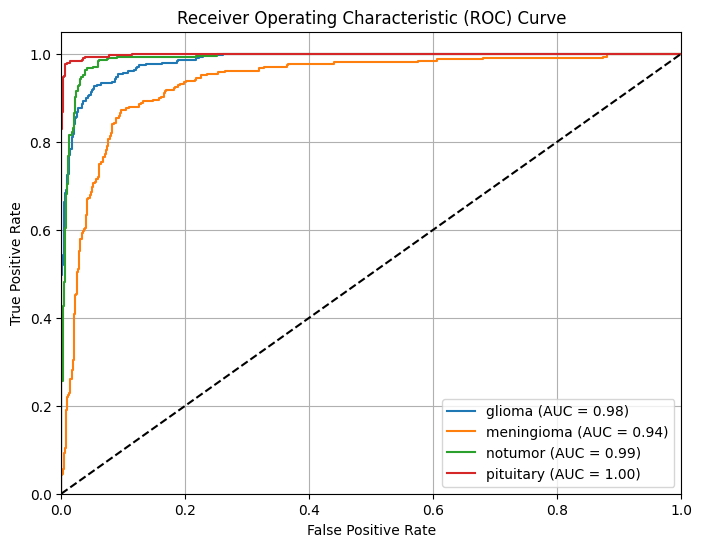

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np
y_true = []
y_pred = []
for images, labels in test_ds:
    y_true.extend(labels.numpy())  
    y_pred.extend(model.predict(images))  

y_true = np.array(y_true)
y_pred = np.array(y_pred)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classnames)):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
plt.figure(figsize=(8, 6))
for i in range(len(classnames)):
    plt.plot(fpr[i], tpr[i], label=f'{classnames[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [7]:
from sklearn.metrics import classification_report

# Make predictions on the test dataset
y_pred = model.predict(test_ds)

# Convert predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Extract true labels from the test dataset
y_true = []
for images, labels in test_ds:
    y_true.extend(np.argmax(labels, axis=1))

# Generate classification report
report = classification_report(y_true, y_pred_labels, target_names=classnames)

print("Classification Report:")
print(report)


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step
Classification Report:
              precision    recall  f1-score   support

      glioma       0.93      0.81      0.87       300
  meningioma       0.81      0.70      0.75       306
     notumor       0.88      0.98      0.93       405
   pituitary       0.89      0.99      0.94       300

    accuracy                           0.88      1311
   macro avg       0.88      0.87      0.87      1311
weighted avg       0.88      0.88      0.87      1311



In [8]:
from sklearn.metrics import classification_report

# Make predictions on the test dataset
y_pred = model.predict(test_ds)

# Convert predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Extract true labels from the test dataset
y_true = []
for images, labels in test_ds:
    y_true.extend(np.argmax(labels, axis=1))

# Generate classification report
report = classification_report(y_true, y_pred_labels, target_names=classnames)

print("Classification Report:")
print(report)

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Classification Report:
              precision    recall  f1-score   support

      glioma       0.93      0.81      0.87       300
  meningioma       0.81      0.70      0.75       306
     notumor       0.88      0.98      0.93       405
   pituitary       0.89      0.99      0.94       300

    accuracy                           0.88      1311
   macro avg       0.88      0.87      0.87      1311
weighted avg       0.88      0.88      0.87      1311



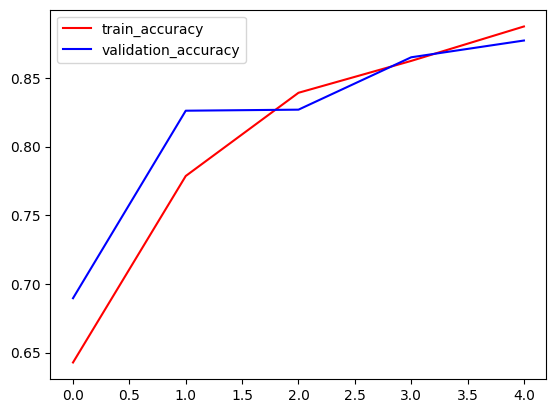

In [9]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], color='red',label='train_accuracy')
plt.plot(history.history['val_accuracy'], color = 'blue', label='validation_accuracy')
plt.legend()
plt.show()

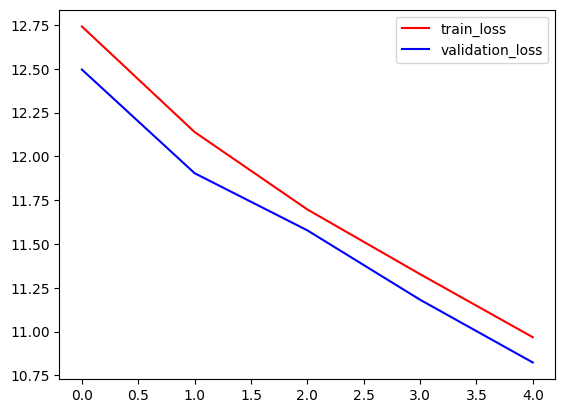

In [10]:

plt.plot(history.history['loss'], color='red',label='train_loss')
plt.plot(history.history['val_loss'], color = 'blue', label='validation_loss')
plt.legend()
plt.show()

2024-05-09 22:20:06.113401: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.86272, expected 2.0465
2024-05-09 22:20:06.113463: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.04967, expected 3.23345
2024-05-09 22:20:06.113474: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.4326, expected 3.61638
2024-05-09 22:20:06.113483: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.46868, expected 4.65247
2024-05-09 22:20:06.113492: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.37814, expected 4.56193
2024-05-09 22:20:06.113500: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.18374, expected 4.36753
2024-05-09 22:20:06.113509: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 5.54872, expected 4.7325
2024-05-09 22:20:06.113518: E external/local_xla/xla/servi

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
pituitary


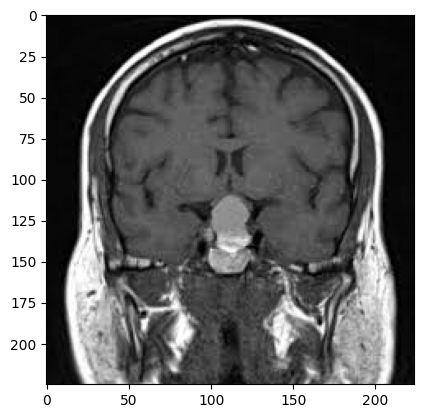

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
img1 = cv2.imread('/kaggle/input/pred-dset/pit_tumor.jpeg')
plt.imshow(img1)
img1 = cv2.resize(img1,(256,256))
input_img1 = np.expand_dims(img1, axis=0)
probs = model.predict(input_img1)
prediction = np.argmax(probs, axis=1)[0]
predicted_class = classnames[prediction]
print(predicted_class)